## **Partie III: Reglage des hyperparametres du modele LightGBM**

##

### **Sommaire**

**I- Importation de l'Environnement et des Données**<br />
&emsp;1.1 Importation des librairies<br />
&emsp;1.2 Importation des données<br />

**2- Optimisation des hyperparamètres avec Optuna du modèle LightGBM**<br />
&emsp;2.1  Performance du modèle<br />
&emsp;&emsp;2.1.1  Fonction objectif à minimiser/maximiser les parametres<br />

**3. Optimisation des parametres avec: Optuna** <br />
&emsp;3.1 Performance du modele avec optuna<br />
&emsp;3.2 Matrice de confusion<br />
&emsp;3.3 Courbe de Roc-Auc

#####

#### **I- Importation de l'Environnement et des Données**

In [70]:
pip install xplotter

Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [106]:
pip install plotly  shap

Note: you may need to restart the kernel to use updated packages.


**1.1 Importation des librairies**

In [73]:
import sys
from yellowbrick.classifier import (
    ClassificationReport,
    ConfusionMatrix,
    DiscriminationThreshold,
    ROCAUC,
    PrecisionRecallCurve,
)
import yellowbrick
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    make_scorer,
    precision_recall_fscore_support,
    log_loss,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.preprocessing import StandardScaler
from optuna import Trial, visualization
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold,
    train_test_split,
)
import sklearn
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats
import time
import optuna
import lightgbm as lgb

# Visualisation
import seaborn as sns
import matplotlib
import plotly
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.float_format', '{:,.2f}'.format)
# pour ne pas imprimer les warnings
warnings.filterwarnings('ignore')

# version des librairies utilisées
print("python version", sys.version)
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version :", sns.__version__)
print("sklearn version :", sklearn.__version__)
print("lightgbm version :", lgbm.__version__)
print("yellowbrick version :", yellowbrick.__version__)
print("optuna version :", optuna.__version__)

python version 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
pandas version : 2.2.3
numpy version : 2.2.4
matplotlib version : 3.10.1
seaborn version : 0.13.2
sklearn version : 1.6.1
lightgbm version : 4.6.0
yellowbrick version : 1.5
optuna version : 4.3.0


#### **1.2 Importation des données**

In [74]:
# Chemin du fichier 
path = r"C:\Users\HP\Documents\projet 7\Deploiement_Projet7\modele\notebook\train_tracking.csv"
df1 =pd.read_csv(path)
# Séparation des features (X) et de la variable cible (y)
X = df1.drop(columns=['TARGET'])
y0 = df1['TARGET']
y = pd.DataFrame(y0)

X.shape, y.shape

((307511, 83), (307511, 1))

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 83 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   AMT_INCOME_TOTAL                         307511 non-null  float64
 1   AMT_CREDIT                               307511 non-null  float64
 2   AMT_ANNUITY                              307511 non-null  float64
 3   NAME_EDUCATION_TYPE                      307511 non-null  float64
 4   DAYS_BIRTH                               307511 non-null  float64
 5   DAYS_EMPLOYED                            307511 non-null  float64
 6   FLAG_WORK_PHONE                          307511 non-null  int64  
 7   FLAG_PHONE                               307511 non-null  int64  
 8   CNT_FAM_MEMBERS                          307511 non-null  float64
 9   REGION_RATING_CLIENT                     307511 non-null  float64
 10  REGION_RATING_CLIENT_W_CITY     

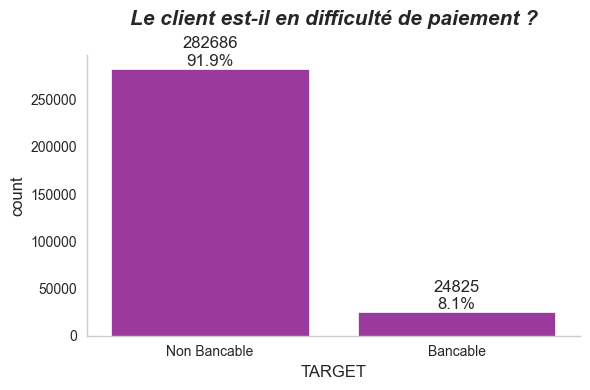

In [76]:
from xplotter.insights import *

colors = ['#a92aac']

loan_map = {1 : "Bancable",
            0 : "Non Bancable"}

fig, ax = plt.subplots(figsize=(6, 4))

plot_countplot(df=y, 
               col='TARGET', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.title("Le client est-il en difficulté de paiement ?\n",
           loc="center", fontsize=15, fontstyle='italic', fontweight = "bold")
plt.tight_layout()
plt.show()

### II- Optimisation des hyperparamètres avec Optuna du modèle LightGBM

2.1 Performance du modèle

In [77]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((215257, 83), (92254, 83), (215257, 1), (92254, 1))

2.1.1  Fonction objectif à minimiser/maximiser les parametres

In [78]:
# Nettoyage des colonnes pour LightGBM
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_valid.columns = X_valid.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

In [79]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    model = lgb.LGBMClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    try:
        score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
        return score
    except Exception as e:
        print(f"[Trial échoué] : {e}")
        return None


#### 3. Optimisation des parametres avec: Optuna  
**Optuna** c’est une librairie open source en Python qui sert à faire de <br />
l'optimisation automatique d'hyperparamètres(basée sur l’optimisation bayésienne).<br />

**Caracteristique**
- Tres rapide a executer
- Explore l’espace des hyperparamètres de manière intelligente


In [82]:
# etude optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # ajustable selon ton temps/calcul

# Résultats
print("Meilleurs hyperparamètres :", study.best_params)
print("Score AUC :", study.best_value)

[I 2025-04-24 01:08:51,798] A new study created in memory with name: no-name-1eced0c9-2b6b-4893-b6ac-6e0df089a220
[I 2025-04-24 01:10:05,086] Trial 0 finished with value: 0.7572130466315883 and parameters: {'learning_rate': 0.025033007594279885, 'num_leaves': 49, 'max_depth': 13, 'n_estimators': 978, 'min_child_samples': 67, 'subsample': 0.7508217856429656, 'colsample_bytree': 0.5265172840440258}. Best is trial 0 with value: 0.7572130466315883.
[I 2025-04-24 01:10:32,616] Trial 1 finished with value: 0.7551486916023361 and parameters: {'learning_rate': 0.020167793956125557, 'num_leaves': 31, 'max_depth': 12, 'n_estimators': 438, 'min_child_samples': 64, 'subsample': 0.7237163320259783, 'colsample_bytree': 0.9248850385405295}. Best is trial 0 with value: 0.7572130466315883.
[I 2025-04-24 01:11:02,497] Trial 2 finished with value: 0.7364145172053058 and parameters: {'learning_rate': 0.12303020889814666, 'num_leaves': 80, 'max_depth': -1, 'n_estimators': 447, 'min_child_samples': 85, 'sub

Meilleurs hyperparamètres : {'learning_rate': 0.08395795609082743, 'num_leaves': 20, 'max_depth': 3, 'n_estimators': 626, 'min_child_samples': 79, 'subsample': 0.661357028726465, 'colsample_bytree': 0.5142723707645603}
Score AUC : 0.757945822290946


In [83]:
print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value : 0.75795
	Best params:
		learning_rate: 0.08395795609082743
		num_leaves: 20
		max_depth: 3
		n_estimators: 626
		min_child_samples: 79
		subsample: 0.661357028726465
		colsample_bytree: 0.5142723707645603


3.1 Performance du modele avec optuna

In [ ]:
model_LGBM = LGBMClassifier(objective="binary",
                            class_weight="balanced",
                            verbose=-1,
                            boosting_type="gbdt",
                            n_estimators=623,
                            learning_rate=0.010901700721791268,
                            max_depth=-1,
                            num_leaves=100,                           
                            min_child_samples=64,    
                            subsample= 0.5076510213913661,                    
                            colsample_bytree=0.5236243943211537,
                            random_state=101,
                            n_jobs=-2)

model_LGBM_fit = model_LGBM.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = model_LGBM_fit.predict(X_valid)

y_pred_lgbm_proba = model_LGBM_fit.predict_proba(X_valid)

In [93]:
# Prédictions probabilistes
y_proba_valid = model_LGBM_fit.predict_proba(X_valid)[:, 1]
y_proba_valid

array([0.33205292, 0.56885585, 0.19020133, ..., 0.43319801, 0.16377309,
       0.212602  ], shape=(92254,))

3.2  Matrice de confusion

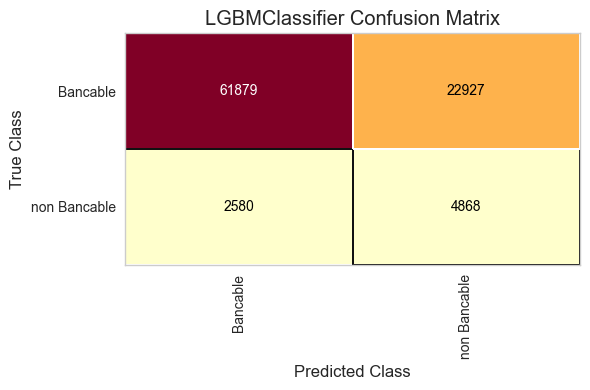

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [87]:
from yellowbrick.classifier import ConfusionMatrix

classes = ['Bancable', 'non Bancable']

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))

cm = ConfusionMatrix(model_LGBM_fit, classes=classes)

cm.fit(X_train, y_train)        # Fit the visualizer and the model
cm.score(X_valid, y_valid)        # Evaluate the model on the test data
cm.show()

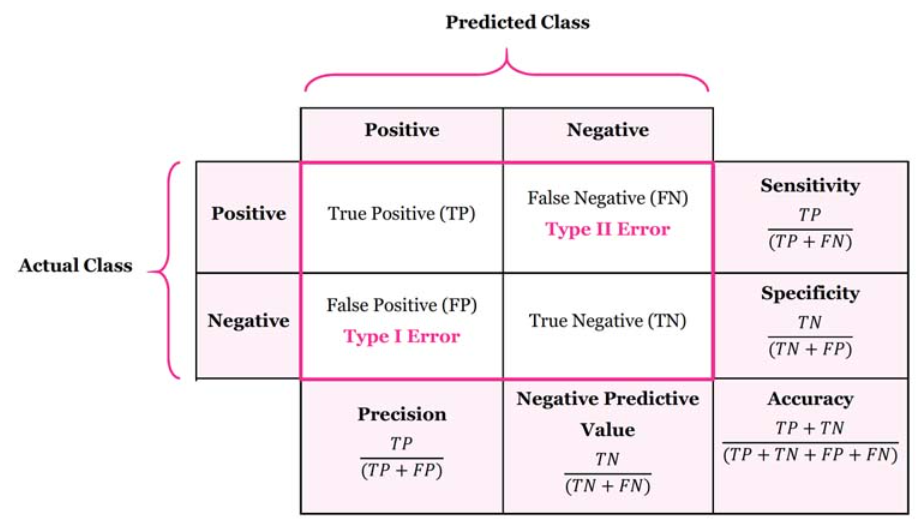

In [88]:
print(classification_report(y_valid, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     84806
           1       0.18      0.65      0.28      7448

    accuracy                           0.72     92254
   macro avg       0.57      0.69      0.55     92254
weighted avg       0.90      0.72      0.78     92254



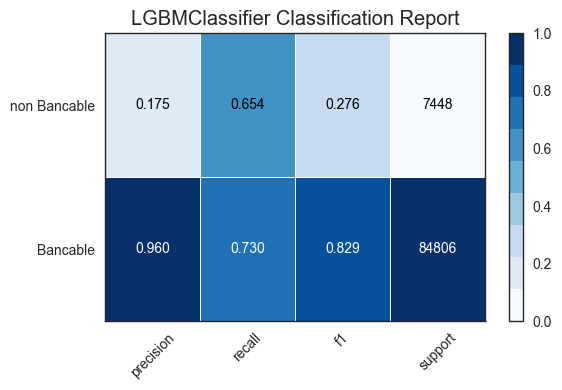

<Axes: title={'center': 'LGBMClassifier Classification Report'}>

In [89]:
# Identifying classes. The classes variable will be useful when using Yellowbrick's visualizers
classes = ['Bancable', 'non Bancable']

sns.set_style("white")
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(model_LGBM_fit, classes=classes, support=True, cmap='Blues')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_valid, y_valid)        # Evaluate the model on the test data
visualizer.show()     

In [90]:
print(f"Train ROC-AUC : {roc_auc_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
print(f"Test ROC-AUC : {roc_auc_score(y_valid, y_pred_lgbm):.2%}")

Train ROC-AUC : 75.19%
Test ROC-AUC : 69.16%


3.3 Courbe de roc Auc

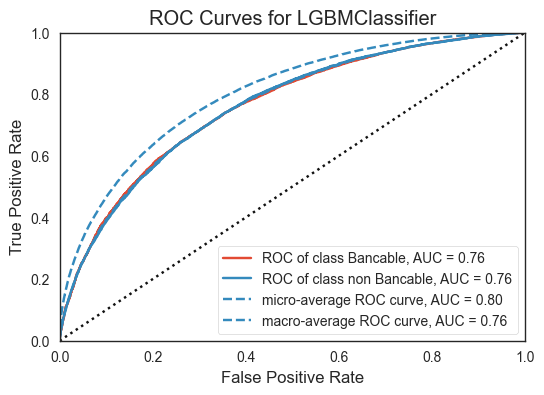

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
from yellowbrick.classifier import ROCAUC

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

vis_rocauc = ROCAUC(model_LGBM_fit, classes=classes, random_state=101)

vis_rocauc.fit(X_train, y_train)        
vis_rocauc.score(X_valid, y_valid)
vis_rocauc.show() 

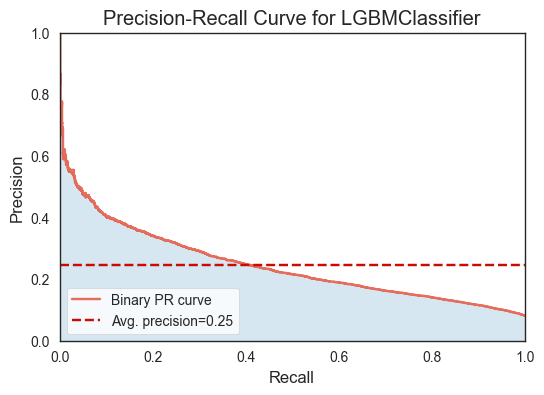

<Axes: title={'center': 'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

vis_prc = PrecisionRecallCurve(model_LGBM_fit, random_state=101)

vis_prc.fit(X_train, y_train)        
vis_prc.score(X_valid, y_valid)     
vis_prc.show()  